# FPLMonkey Notebook

In [10]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from helpers import *
from pathlib import Path
from fastai.tabular.all import *
from matplotlib import style

In [11]:
path = Path('./')

In [12]:
train_df = pd.read_csv(path/'data/train_v7.csv', index_col=0, dtype={'season':str})

/Users/kjetildyrland/anaconda3/envs/fplmonkey/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (39,40) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [13]:
train_df.head()

,player,gw,position,minutes,team,opponent_team,relative_market_value_team,relative_market_value_opponent_team,was_home,total_points,...,npxg,xa,sca,gca,passes_completed,passes,passes_pct,carries,dribbles_completed,dribbles
0,Aaron Cresswell,1,2,0,West Ham United,Chelsea,NaN,NaN,False,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Aaron Lennon,1,3,15,Everton,Tottenham Hotspur,NaN,NaN,True,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Aaron Ramsey,1,3,60,Arsenal,Liverpool,NaN,NaN,True,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Abdoulaye Doucouré,1,3,0,Watford,Southampton,NaN,NaN,False,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Abdul Rahman Baba,1,2,0,Chelsea,West Ham United,NaN,NaN,True,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
train_df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 107552 entries, 0 to 107551
Data columns (total 58 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   player                                      107552 non-null  object 
 1   gw                                          107552 non-null  int64  
 2   position                                    107552 non-null  int64  
 3   minutes                                     107552 non-null  int64  
 4   team                                        107552 non-null  object 
 5   opponent_team                               107552 non-null  object 
 6   relative_market_value_team                  39489 non-null   float64
 7   relative_market_value_opponent_team         39466 non-null   float64
 8   was_home                                    107552 non-null  bool   
 9   total_points                                107552 non-null  int64  
 

In [15]:
train_df[train_df['season']=='1920'].head()

,player,gw,position,minutes,team,opponent_team,relative_market_value_team,relative_market_value_opponent_team,was_home,total_points,...,npxg,xa,sca,gca,passes_completed,passes,passes_pct,carries,dribbles_completed,dribbles
67936,Aaron Cresswell,1,2,90,West Ham United,Manchester City,0.739196,2.727025,True,0,...,0.0,0.0,1.0,0.0,33.0,40.0,82.5,33.0,0.0,2.0
67937,Aaron Lennon,1,3,6,Burnley,Southampton,0.441799,0.624210,True,1,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
67938,Aaron Mooy,1,3,0,Brighton and Hove Albion,Watford,0.476156,0.555819,False,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
67939,Aaron Ramsdale,1,1,90,Bournemouth,Sheffield United,0.687124,0.150631,True,2,...,0.0,0.0,0.0,0.0,16.0,25.0,64.0,10.0,0.0,0.0
67940,Aaron Wan-Bissaka,1,2,90,Manchester United,Chelsea,1.679697,1.798870,True,8,...,0.0,0.1,1.0,0.0,43.0,52.0,82.7,42.0,2.0,5.0


In [16]:
# add a bunch of lag features
lag_train_df, team_lag_vars = team_lag_features(train_df, ['total_points'], ['all', 1, 2, 3, 4, 5, 10])
lag_train_df, player_lag_vars = player_lag_features(lag_train_df, ['total_points'], ['all', 1, 2, 3, 4, 5, 10])

In [17]:
# set validaton point/length and categorical/continuous variables
valid_season = '1920'
valid_gw = 20
valid_len = 5
cat_vars = ['gw', 'season', 'position', 'team', 'opponent_team', 'was_home']
cont_vars = ['minutes', 'relative_market_value_team_season', 'relative_market_value_opponent_team_season']
dep_var = ['total_points']

In [18]:
# we want to set gw and season as ordered categorical variables
# need lists with ordered categories
ordered_gws = list(range(1,39))
ordered_seasons = ['1617', '1718', '1819', '1920']

In [19]:
# set as categories with correct order 
lag_train_df['gw'] = lag_train_df['gw'].astype('category')
lag_train_df['season'] = lag_train_df['season'].astype('category')

lag_train_df['gw'].cat.set_categories(ordered_gws, ordered=True, inplace=True)
lag_train_df['season'].cat.set_categories(ordered_seasons, ordered=True, inplace=True)

In [20]:
# dependent variable needs to be float
lag_train_df['total_points'] = lag_train_df['total_points'].astype('float64')

In [21]:
train_valid_df, train_idx, valid_idx = create_lag_train(lag_train_df, 
                                                      cat_vars, cont_vars, 
                                                      player_lag_vars, team_lag_vars, dep_var,
                                                      valid_season, valid_gw, valid_len)

train_valid_df[player_lag_vars + team_lag_vars] = train_valid_df[player_lag_vars + team_lag_vars].fillna(0)

In [22]:
train_valid_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81435 entries, 0 to 81434
Data columns (total 39 columns):
 #   Column                                      Non-Null Count  Dtype   
---  ------                                      --------------  -----   
 0   gw                                          81435 non-null  category
 1   minutes                                     81435 non-null  int64   
 2   minutes_last_1                              81435 non-null  float64 
 3   minutes_last_10                             81435 non-null  float64 
 4   minutes_last_2                              81435 non-null  float64 
 5   minutes_last_3                              81435 non-null  float64 
 6   minutes_last_4                              81435 non-null  float64 
 7   minutes_last_5                              81435 non-null  float64 
 8   minutes_last_all                            81435 non-null  int64   
 9   opponent_team                               81435 non-null  object  
 10

In [23]:
# need to remove 0 minute rows from the validation set
train_valid_df = pd.concat([train_valid_df.loc[train_idx],
                            train_valid_df.loc[valid_idx][train_valid_df.loc[valid_idx]['minutes'] > 0]],
                           ignore_index=True)

In [24]:
# and redo the valid indexes
valid_idx = range(valid_idx[0], train_valid_df.index.max() + 1)

In [25]:
# create train/valid splits
splits = (list(train_idx), list(valid_idx))
valid_idx

range(78390, 79778)

In [26]:
train_valid_df[cat_vars + ['player']].nunique()

gw                 38
season              4
position            4
team               29
opponent_team      29
was_home            2
player           1244
dtype: int64

In [27]:
cat_vars + ['player']

['gw', 'season', 'position', 'team', 'opponent_team', 'was_home', 'player']

In [28]:
# processors - categorify categorical variables and normalize continuous variables
# fill missing not used because new teams are almost certainly well below the league average
procs=[Categorify, Normalize]
to_nn = TabularPandas(train_valid_df, procs, cat_vars + ['player'], cont_vars, #+ player_lag_vars + team_lag_vars,
                      splits=splits, y_names=dep_var)

In [29]:
# dls = to_nn.dataloaders()
dls = to_nn.dataloaders()

In [30]:
dls.show_batch()

,gw,season,position,team,opponent_team,was_home,player,minutes,relative_market_value_team_season,relative_market_value_opponent_team_season,total_points
0,16,1819,1,Chelsea,Manchester City,True,Kepa Arrizabalaga,9.000000e+01,2.540586,2.540586,7.0
1,23,1617,2,Manchester United,Hull City,True,Chris Smalling,3.600000e+01,1.983179,0.494447,1.0
2,33,1617,3,West Bromwich Albion,Liverpool,True,Claudio Yacob,6.300000e+01,0.428062,1.465860,2.0
3,30,1819,2,Everton,Newcastle United,False,Seamus Coleman,-9.094729e-07,1.039221,0.483921,0.0
4,34,1617,2,Liverpool,Crystal Palace,True,Joseph Gomez,-9.094729e-07,1.465860,0.802197,0.0
5,29,1718,3,Southampton,Stoke City,True,Pierre-Emile Højbjerg,-9.094729e-07,0.809578,0.581587,0.0
6,25,1718,2,West Bromwich Albion,Manchester City,False,Nathan Ferguson,-9.094729e-07,0.541354,2.016093,0.0
7,25,1819,4,Crystal Palace,Fulham,True,Wilfried Zaha,-9.094729e-07,0.634856,0.405284,0.0
8,29,1718,2,Everton,Burnley,False,Ashley Williams,8.500000e+01,1.134226,0.316798,-2.0
9,13,1617,3,Bournemouth,Arsenal,False,Jordon Ibe,2.000000e+01,0.384921,1.944129,1.0


In [31]:
# set range of predictions - minimum to current max
max_y = np.max(lag_train_df['total_points'])
min_y = np.min(lag_train_df['total_points'])
y_range = (-1, max_y)

In [32]:
# learn = tabular_learner(dls, y_range=y_range, layers=[1000,500], ps=[0.001,0.01], emb_drop=0.04,
#                         n_out=1, loss_func=F.mse_loss, metrics=rmse)

learn = tabular_learner(dls, y_range=y_range, layers=[500,250], loss_func=F.mse_loss, metrics=rmse)

SuggestedLRs(lr_min=0.33113112449646, lr_steep=0.0020892962347716093)

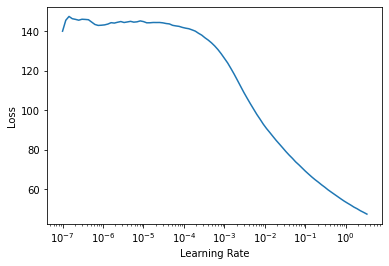

In [33]:
learn.lr_find()

In [34]:
# [500, 250]
learn.fit_one_cycle(2, 5e-3, wd=0.2)

epoch,train_loss,valid_loss,_rmse,time
0,3.793744,7.610191,2.758658,00:20
1,3.576140,6.848428,2.616950,00:21


In [35]:
# check that rmse matches the training output above
preds,targs = learn.get_preds()
r_mse(preds,targs)

2.61695

In [36]:
preds.size()


torch.Size([1388, 1])

In [40]:
valid_gws = np.arange(valid_gw, valid_gw + valid_len, 1)
print(valid_gws)

[20 21 22 23 24]


In [48]:
preds_gw_df = train_valid_df[['player'] + cat_vars + cont_vars + dep_var].copy()
preds_gw_df = preds_gw_df[preds_gw_df['gw'] == valid_gw]
preds_gw_df = preds_gw_df[preds_gw_df['season'] == valid_season]
preds_gw_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 276 entries, 78390 to 78665
Data columns (total 11 columns):
 #   Column                                      Non-Null Count  Dtype   
---  ------                                      --------------  -----   
 0   player                                      276 non-null    object  
 1   gw                                          276 non-null    category
 2   season                                      276 non-null    category
 3   position                                    276 non-null    int64   
 4   team                                        276 non-null    object  
 5   opponent_team                               276 non-null    object  
 6   was_home                                    276 non-null    bool    
 7   minutes                                     276 non-null    int64   
 8   relative_market_value_team_season           276 non-null    float64 
 9   relative_market_value_opponent_team_season  276 non-null    float64 
 

In [1]:
preds_gw_df['predicted_points'] = preds.data.cpu().numpy()
preds_gw_df

NameError: name 'preds' is not defined

In [ ]:
# get the precited points of a single player in a gw
player_prediction = preds_gw_df[preds_gw_df['player'] == 'Martin Kelly'].predicted_points
player_prediction.iloc[0]

In [ ]:
# ordered by precited points
preds_gw_df.sort_values(by='predicted_points', ascending=False).head()

In [ ]:
preds_gw_df.to_csv('data/predictions_for_season_' + str(valid_season) + '_gw_' + str(valid_gw) + '.csv')